In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from ssa import *

from darts import TimeSeries
from darts.models import LinearRegressionModel
from darts.metrics import mape, rmse
import pandas as pd
import numpy as np
from darts import TimeSeries
from darts.models import LinearRegressionModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.missing_values import extract_subseries
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings

import matplotlib.pyplot as plt

from darts.dataprocessing.transformers import Scaler
from darts.datasets import AirPassengersDataset
from darts.metrics import mape
from darts.models import (
    ExponentialSmoothing,
    KalmanForecaster,
    LinearRegressionModel,
    NaiveDrift,
    NaiveEnsembleModel,
    NaiveSeasonal,
    RandomForest,
    RegressionEnsembleModel,
    TCNModel,
)
from darts.models import RegressionModel
from sklearn.linear_model import Ridge

from darts.utils.timeseries_generation import (
    datetime_attribute_timeseries as dt_attr,
)

warnings.filterwarnings("ignore")

import logging

logging.disable(logging.CRITICAL)

In [2]:
data = pd.read_parquet("../data/afrr_price.parquet")

In [3]:
data = data[['wind_offshore_dayahead', 'wind_onshore_dayahead',
       'solar_dayahead','aFRR_DownCapPriceEUR', 'aFRR_UpCapPriceEUR', 'load_forecasts',
       'da_price', 'prod_unbalance']]

In [4]:
ts = data["aFRR_UpCapPriceEUR"]
ssa_ts = mySSA(data["aFRR_UpCapPriceEUR"])
ssa_ts.embed(embedding_dimension=128, suspected_frequency=24, verbose=True)
ssa_ts.decompose(True)
components = [i for i in range(10)]
ts_clean = ssa_ts.view_reconstruction(*[ssa_ts.Xs[i] for i in components], names=components, return_df=True, plot=False)

----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  120
Trajectory dimensions	: (120, 3265)
Complete dimension	: (120, 3265)
Missing dimension     	: (120, 0)
----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 120
Dimension of projection space	: 113
Characteristic of projection	: 0.9997


In [5]:
data["aFRR_UpCapPriceEUR_cl"] = ts_clean.values

In [6]:
target_col = 'aFRR_UpCapPriceEUR_cl'
exog_cols = ['wind_offshore_dayahead', 'wind_onshore_dayahead', 
             'solar_dayahead', 'load_forecasts', 'da_price', 'prod_unbalance']

# Create TimeSeries objects
target_series = TimeSeries.from_series(data[target_col], freq="1h")
covariates = TimeSeries.from_dataframe(data[exog_cols], freq="1h")

# Extract subseries without missing values
target_subseries = extract_subseries(
    series=target_series,
    min_gap_size=1
)

covariates_subseries = extract_subseries(
    series=covariates,
    min_gap_size=1,
    mode='all'
)

target_clean = max(target_subseries, key=len)
covariates_clean = max(covariates_subseries, key=len)
start_time = max(target_clean.start_time(), covariates_clean.start_time())
end_time = min(target_clean.end_time(), covariates_clean.end_time())
target_final = target_clean.slice(start_time, end_time)
covariates_final = covariates_clean.slice(start_time, end_time)

print(f"Clean aligned series length: {len(target_final)}")

train_cutoff = int(len(target_final) * 0.5)
train_target = target_final[:train_cutoff]
test_target = target_final[train_cutoff:]

max_past_lag = 24

train_covariates = covariates_final[:train_cutoff]
test_covariates_start = train_cutoff - max_past_lag
test_covariates = covariates_final[test_covariates_start:]

# Scale the data
scaler_target = Scaler()
scaler_covariates = Scaler()
train_target_scaled = scaler_target.fit_transform(train_target)
test_target_scaled = scaler_target.fit_transform(test_target)
train_covariates_scaled = scaler_covariates.fit_transform(train_covariates)
test_covariates_scaled = scaler_covariates.transform(test_covariates)
full_covariates = scaler_covariates.transform(covariates_final)

Clean aligned series length: 1223


In [14]:
from gp_regressor import GPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

In [ ]:
kernel = DotProduct() + WhiteKernel()

model = GPRegressor(
    lags=12,                    
    lags_past_covariates=12, 
	lags_future_covariates=[0, 1, 2],   
    output_chunk_length=24,     
    kernel=kernel
)

model.fit(
    train_target_scaled,
    past_covariates=full_covariates,
	future_covariates=full_covariates,
)

pred_series = model.predict(
    n=24,                      
    num_samples=100,
    past_covariates=full_covariates, 
	future_covariates=full_covariates
)


backtest_forecasts = model.historical_forecasts(
    series=test_target_scaled,
    past_covariates=test_covariates_scaled,
    future_covariates=full_covariates,
    start=0.05,
    forecast_horizon=1,
	num_samples=1, 
	predict_likelihood_parameters=True,
    stride=24,
    retrain=False,
    verbose=True)

historical forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

<Axes: xlabel='time_utc'>

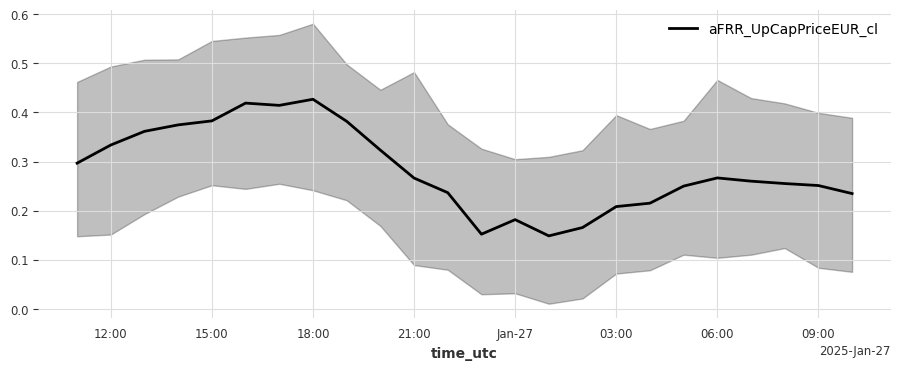

In [57]:
pred_series = model.predict(
    n=24,                      
    num_samples=100,
    past_covariates=full_covariates, 
	future_covariates=full_covariates
)
pred_series.plot()

In [ ]:
model_lr = LinearRegressionModel(output_chunk_length=24,     
                                lags=list(range(-1, -1, -1)), 
                                lags_past_covariates=list(range(-1, -8, -1)),
                                lags_future_covariates=list(range(1, 3, 1)),
                                likelihood="quantile")

model_rf = RandomForest(lags=12, output_chunk_length=24)
model_ridge = RegressionModel(model=Ridge(alpha=1.0), lags=12, output_chunk_length=24) # example using Ridge regression

ensamble_model = RegressionEnsembleModel(forecasting_models=[model_lr],
                                         regression_train_n_points=1)

ensamble_model.fit(
    series=train_target_scaled,
    future_covariates=full_covariates,
    past_covariates=train_covariates_scaled)

backtest_forecasts = ensamble_model.historical_forecasts(
    series=test_target_scaled,
    past_covariates=test_covariates_scaled,
    future_covariates=full_covariates,
    start=0.1,
    forecast_horizon=24,
    stride=24,
    retrain=True,
    verbose=True)

historical forecasts:   0%|          | 0/22 [00:00<?, ?it/s]